## Assignment : 14

<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [ ]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
# input_layer = Input(shape=(n,))
# embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
# flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

Make sure the test auc for all the three models is more than 0.70 and atleast 1 models test auc should be greater than 0.75

In [1]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn.metrics import roc_auc_score

from keras.layers import LeakyReLU
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape
from keras import Input, Model
from keras.regularizers import l2
from keras.initializers import he_normal
from tensorflow.keras.callbacks import TensorBoard
from time import time
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.7/dist-packages (2.4.3)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/LSTM_Assignment/'

data		       glove_vectors  modelcheckpoint
glove.6B.300d.txt.zip  logs	      preprocessed_data.csv


In [5]:
glovevectorfile = open('/content/drive/My Drive/LSTM_Assignment/glove_vectors', 'rb')
glovevector = pickle.load(glovevectorfile)

In [6]:
glovevector['humongous'].shape

(300,)

In [7]:
processed_data = pd.read_csv('/content/drive/My Drive/LSTM_Assignment/preprocessed_data.csv')
processed_data.shape

(109248, 9)

In [8]:
# processed_data['remaining_input'] = processed_data['teacher_number_of_previously_posted_projects'] + processed_data['price']

In [9]:
processed_data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

In [10]:
processed_data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [11]:
Y = processed_data['project_is_approved'].values
processed_data.drop(['project_is_approved'], axis=1, inplace=True)
X = processed_data
processed_data.shape

(109248, 8)

# Splitting the data into train and test

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.2, stratify=Y_train)

print('Train data : ', X_train.shape, Y_train.shape)
print('Cv data : ', X_cv.shape, Y_cv.shape)
print('Test data : ', X_test.shape, Y_test.shape)

Train data :  (69918, 8) (69918,)
Cv data :  (17480, 8) (17480,)
Test data :  (21850, 8) (21850,)


In [13]:
X_train_original = X_train
Y_train_original = Y_train
X_cv_original = X_cv
Y_cv_original = Y_cv
X_test_original = X_test
Y_test_original = Y_test

In [14]:
from numpy import savetxt

X_train_original.to_csv('/content/drive/My Drive/LSTM_Assignment/data/X_train.csv')
Y_train_df = pd.DataFrame(Y_train_original)
Y_train_df.to_csv('/content/drive/My Drive/LSTM_Assignment/data/Y_train.csv',index=False)

X_cv_original.to_csv('/content/drive/My Drive/LSTM_Assignment/data/X_cv.csv')
Y_cv_df = pd.DataFrame(Y_cv_original)
Y_cv_df.to_csv('/content/drive/My Drive/LSTM_Assignment/data/Y_cv.csv',index=False)

X_test_original.to_csv('/content/drive/My Drive/LSTM_Assignment/data/X_test.csv')
Y_test_df = pd.DataFrame(Y_test_original)
Y_test_df.to_csv('/content/drive/My Drive/LSTM_Assignment/data/Y_test.csv',index=False)


# Categorical Featurization

In [15]:
corpus = [
    'The phone is very fast',
    'The phone is not bad',
    'I have good phone',
]

words_dict = {}

for sent in corpus:
    words = sent.split()
    for word in words:
        if(word in words_dict):
            words_dict[word] += 1
        else:
            words_dict[word] = 1

print(words_dict)

sortedList = sorted(words_dict.items(), key = lambda x:x[1], reverse=True)
print(sortedList)

rank = 1
final_dict = {}

for item in sortedList:
    item = list(item)
    final_dict[item[0]] = rank
    rank += 1

print(final_dict)

tokenize_list = []
for sent in corpus:
    words = sent.split()
    tokenize_sublist = []
    for word in words:
        if word in final_dict:
            tokenize_sublist.append(final_dict[word])

    tokenize_list.append(tokenize_sublist)

print(tokenize_list)

{'The': 2, 'phone': 3, 'is': 2, 'very': 1, 'fast': 1, 'not': 1, 'bad': 1, 'I': 1, 'have': 1, 'good': 1}
[('phone', 3), ('The', 2), ('is', 2), ('very', 1), ('fast', 1), ('not', 1), ('bad', 1), ('I', 1), ('have', 1), ('good', 1)]
{'phone': 1, 'The': 2, 'is': 3, 'very': 4, 'fast': 5, 'not': 6, 'bad': 7, 'I': 8, 'have': 9, 'good': 10}
[[2, 1, 3, 4, 5], [2, 1, 3, 6, 7], [8, 9, 10, 1]]


In [16]:
def fit_transform_train_data(train_data):
    bag_of_words = CountVectorizer(lowercase = False)
    bow_words = bag_of_words.fit_transform(train_data)

    freq = bow_words.sum(axis=0).A1
    index = freq.argsort()
    words = bag_of_words.get_feature_names()
    
    rank_dict = {}
    rank = 1
    for item in index[::-1]:
        feature_name = words[item]
        rank_dict[feature_name] = rank
        rank += 1
    
    return [words, rank_dict]

def transform_data(data, rank_dict):
    token_list = []
    for sent in data:
        words = sent.split()
        token_sublist = []
        for word in words:
            if word in words:
                token_sublist.append(rank_dict[word])

        token_list.append(token_sublist)

    return token_list

In [17]:
features, rank_dict = fit_transform_train_data(processed_data['school_state'])
print(features, rank_dict)

tokenized_data = transform_data(processed_data['school_state'], rank_dict)
print(processed_data['school_state'][5])
print(tokenized_data[5])
print(len(features))

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy'] {'ca': 1, 'tx': 2, 'ny': 3, 'fl': 4, 'nc': 5, 'il': 6, 'ga': 7, 'sc': 8, 'mi': 9, 'pa': 10, 'in': 11, 'mo': 12, 'oh': 13, 'la': 14, 'ma': 15, 'wa': 16, 'ok': 17, 'nj': 18, 'az': 19, 'va': 20, 'wi': 21, 'al': 22, 'ut': 23, 'tn': 24, 'ct': 25, 'md': 26, 'nv': 27, 'ms': 28, 'ky': 29, 'or': 30, 'mn': 31, 'co': 32, 'ar': 33, 'id': 34, 'ia': 35, 'ks': 36, 'nm': 37, 'dc': 38, 'hi': 39, 'me': 40, 'wv': 41, 'nh': 42, 'ak': 43, 'de': 44, 'ne': 45, 'sd': 46, 'ri': 47, 'mt': 48, 'nd': 49, 'wy': 50, 'vt': 51}
ca
[1]
51


## One Hot Encoding of Categorical Features

In [18]:
(school_state_feat, rank_dict) = fit_transform_train_data(X_train['school_state'].values)

X_train_school_state_ohe = transform_data(X_train['school_state'].values, rank_dict)
X_cv_school_state_ohe = transform_data(X_cv['school_state'].values, rank_dict)
X_test_school_state_ohe = transform_data(X_test['school_state'].values, rank_dict)

print(len(X_train_school_state_ohe), Y_train.shape)
print(len(X_cv_school_state_ohe), Y_cv.shape)
print(len(X_test_school_state_ohe), Y_test.shape)
print(school_state_feat)
print(len(school_state_feat))

69918 (69918,)
17480 (17480,)
21850 (21850,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
51


In [19]:
(project_grade_category_feat, rank_dict) = fit_transform_train_data(X_train['project_grade_category'].values)

X_train_project_grade_category_ohe = transform_data(X_train['project_grade_category'].values, rank_dict)
X_cv_project_grade_category_ohe = transform_data(X_cv['project_grade_category'].values, rank_dict)
X_test_project_grade_category_ohe = transform_data(X_test['project_grade_category'].values, rank_dict)

print(len(X_train_project_grade_category_ohe), Y_train.shape)
print(len(X_cv_project_grade_category_ohe), Y_cv.shape)
print(len(X_test_project_grade_category_ohe), Y_test.shape)
print(project_grade_category_feat)
print(len(project_grade_category_feat))

69918 (69918,)
17480 (17480,)
21850 (21850,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
4


In [20]:
(clean_categories_feat, rank_dict) = fit_transform_train_data(X_train['clean_categories'].values)

X_train_clean_categories_ohe = transform_data(X_train['clean_categories'].values, rank_dict)
X_cv_clean_categories_ohe = transform_data(X_cv['clean_categories'].values, rank_dict)
X_test_clean_categories_ohe = transform_data(X_test['clean_categories'].values, rank_dict)

print(len(X_train_clean_categories_ohe), Y_train.shape)
print(len(X_cv_clean_categories_ohe), Y_cv.shape)
print(len(X_test_clean_categories_ohe), Y_test.shape)
print(clean_categories_feat)
print(len(clean_categories_feat))

69918 (69918,)
17480 (17480,)
21850 (21850,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
9


In [21]:
(clean_subcategories_feat, rank_dict) = fit_transform_train_data(X_train['clean_subcategories'].values)

X_train_clean_subcategories_ohe = transform_data(X_train['clean_subcategories'].values, rank_dict)
X_cv_clean_subcategories_ohe = transform_data(X_cv['clean_subcategories'].values, rank_dict)
X_test_clean_subcategories_ohe = transform_data(X_test['clean_subcategories'].values, rank_dict)

print(len(X_train_clean_subcategories_ohe), Y_train.shape)
print(len(X_cv_clean_subcategories_ohe), Y_cv.shape)
print(len(X_test_clean_subcategories_ohe), Y_test.shape)
print(clean_subcategories_feat)
print(len(clean_subcategories_feat))

69918 (69918,)
17480 (17480,)
21850 (21850,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
30


In [22]:
(teacher_prefix_feat, rank_dict) = fit_transform_train_data(X_train['teacher_prefix'].values)

X_train_teacher_prefix_ohe = transform_data(X_train['teacher_prefix'].values, rank_dict)
X_cv_teacher_prefix_ohe = transform_data(X_cv['teacher_prefix'].values, rank_dict)
X_test_teacher_prefix_ohe = transform_data(X_test['teacher_prefix'].values, rank_dict)

print(len(X_train_teacher_prefix_ohe), Y_train.shape)
print(len(X_cv_teacher_prefix_ohe), Y_cv.shape)
print(len(X_test_teacher_prefix_ohe), Y_test.shape)
print(teacher_prefix_feat)
print(len(teacher_prefix_feat))

69918 (69918,)
17480 (17480,)
21850 (21850,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
5


In [23]:

#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
def padded(encoded_docs):  
  max_length = 300
  padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
  return padded_docs

In [24]:
#https://stackoverflow.com/posts/51956230/revisions
t = Tokenizer()
t.fit_on_texts(X_train['essay'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(X_train['essay'])
X_train_essay = padded(encoded_docs)

In [25]:
vocab_size

47484

In [26]:
X_train_essay.shape

(69918, 300)

In [27]:
encoded_docs = t.texts_to_sequences(X_cv['essay'])
X_cv_essay = padded(encoded_docs)

encoded_docs = t.texts_to_sequences(X_test['essay'])
X_test_essay = padded(encoded_docs)

In [28]:
!unzip '/content/drive/My Drive/LSTM_Assignment/glove.6B.300d.txt.zip'

Archive:  /content/drive/My Drive/LSTM_Assignment/glove.6B.300d.txt.zip
  inflating: glove.6B.300d.txt       


In [29]:
embeddings_index = dict()
f = open('/content/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

In [30]:
len(embeddings_index)

400000

In [31]:
embeddings_index['feel'].shape

(300,)

In [32]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
	  embedding_vector = embeddings_index.get(word)
	  if embedding_vector is not None:
		    embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(47484, 300)

In [34]:
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_cv = to_categorical(Y_cv)
Y_test = to_categorical(Y_test)

In [35]:
Y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [36]:
class_weight = compute_class_weight("balanced", classes= np.unique(Y),y=Y)

In [37]:
class_weight

array([3.30214001, 0.58921753])

In [38]:
max_length = 1

X_train_school_state_ohe = pad_sequences(X_train_school_state_ohe, maxlen=max_length)
X_cv_school_state_ohe = pad_sequences(X_cv_school_state_ohe, maxlen=max_length)
X_test_school_state_ohe = pad_sequences(X_test_school_state_ohe, maxlen=max_length)

print(X_train_school_state_ohe.shape)
print(X_train_school_state_ohe[0])

(69918, 1)
[3]


In [39]:
X_train_project_grade_category_ohe = pad_sequences(X_train_project_grade_category_ohe, maxlen=max_length)
X_cv_project_grade_category_ohe = pad_sequences(X_cv_project_grade_category_ohe, maxlen=max_length)
X_test_project_grade_category_ohe = pad_sequences(X_test_project_grade_category_ohe, maxlen=max_length)

print(X_train_project_grade_category_ohe.shape)
print(X_train_project_grade_category_ohe[0])

(69918, 1)
[1]


In [40]:
X_train_clean_categories_ohe = pad_sequences(X_train_clean_categories_ohe, maxlen=max_length)
X_cv_clean_categories_ohe = pad_sequences(X_cv_clean_categories_ohe, maxlen=max_length)
X_test_clean_categories_ohe = pad_sequences(X_test_clean_categories_ohe, maxlen=max_length)

print(X_train_clean_categories_ohe.shape)
print(X_train_clean_categories_ohe[0])

(69918, 1)
[2]


In [41]:
X_train_clean_subcategories_ohe = pad_sequences(X_train_clean_subcategories_ohe, maxlen=max_length)
X_cv_clean_subcategories_ohe = pad_sequences(X_cv_clean_subcategories_ohe, maxlen=max_length)
X_test_clean_subcategories_ohe = pad_sequences(X_test_clean_subcategories_ohe, maxlen=max_length)

print(X_train_clean_subcategories_ohe.shape)
print(X_train_clean_subcategories_ohe[0])

(69918, 1)
[2]


In [42]:
X_train_teacher_prefix_ohe = pad_sequences(X_train_teacher_prefix_ohe, maxlen=max_length)
X_cv_teacher_prefix_ohe = pad_sequences(X_cv_teacher_prefix_ohe, maxlen=max_length)
X_test_teacher_prefix_ohe = pad_sequences(X_test_teacher_prefix_ohe, maxlen=max_length)

print(X_train_teacher_prefix_ohe.shape)
print(X_train_teacher_prefix_ohe[0])

(69918, 1)
[1]


In [43]:
def auc_func(y_true, y_pred):
    _auc = roc_auc_score(y_true, y_pred, average='micro')
    return _auc

def auc_score(y_true, y_pred):
    return tf.py_function(auc_func, (y_true, y_pred), tf.double)

In [44]:
X_train_essay_mat = embedding_matrix

In [45]:
embedding_matrix.shape

(47484, 300)

# Model 1

In [51]:
input1 = Input(shape=(300,))
i1 = Embedding(input_dim= embedding_matrix.shape[0], output_dim = 300, weights = [embedding_matrix], input_length = 300, trainable = False)(input1)
i1 = LSTM(128, recurrent_dropout=0.3, kernel_regularizer=l2(0.001), return_sequences=True)(i1)
i1 = Flatten()(i1)

cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}

for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

input2 = Input(shape=(1,))
i2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'])(input2)
i2 = Flatten()(i2)

input3 = Input(shape=(1,))
i3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
i3 = Flatten()(i3)

input4 = Input(shape=(1,))
i4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
i4 = Flatten()(i4)

input5 = Input(shape=(1,))
i5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
i5 = Flatten()(i5)

input6 = Input(shape=(1,))
i6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
i6 = Flatten()(i6)

input7 = Input(shape=(1,))
i7 = Dense(16, kernel_initializer = he_normal(), kernel_regularizer = l2(0.0001))(input7)

concat = concatenate([i1, i2, i3, i4, i5, i6, i7])

i = Dense(64, kernel_initializer = he_normal(), kernel_regularizer = l2(0.0001))(concat)
i = Dropout(0.5)(i)
i = LeakyReLU()(i)
i = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(i)
i = Dropout(0.5)(i)
i = BatchNormalization()(i)
i = LeakyReLU()(i)
i = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(i)
i = LeakyReLU()(i)

output = Dense(2, activation = 'softmax')(i)
model = Model([input1, input2, input3, input4, input5, input6, input7], output)
model.run_eagerly = True

adam = tf.keras.optimizers.Adam(learning_rate=0.0007, decay = 1e-4)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [auc_score])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 300, 300)     14245200    input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 1)]          0                                            
____________________________________________________________________________________________

In [47]:
X_train_essay_mat.shape

(47484, 300)

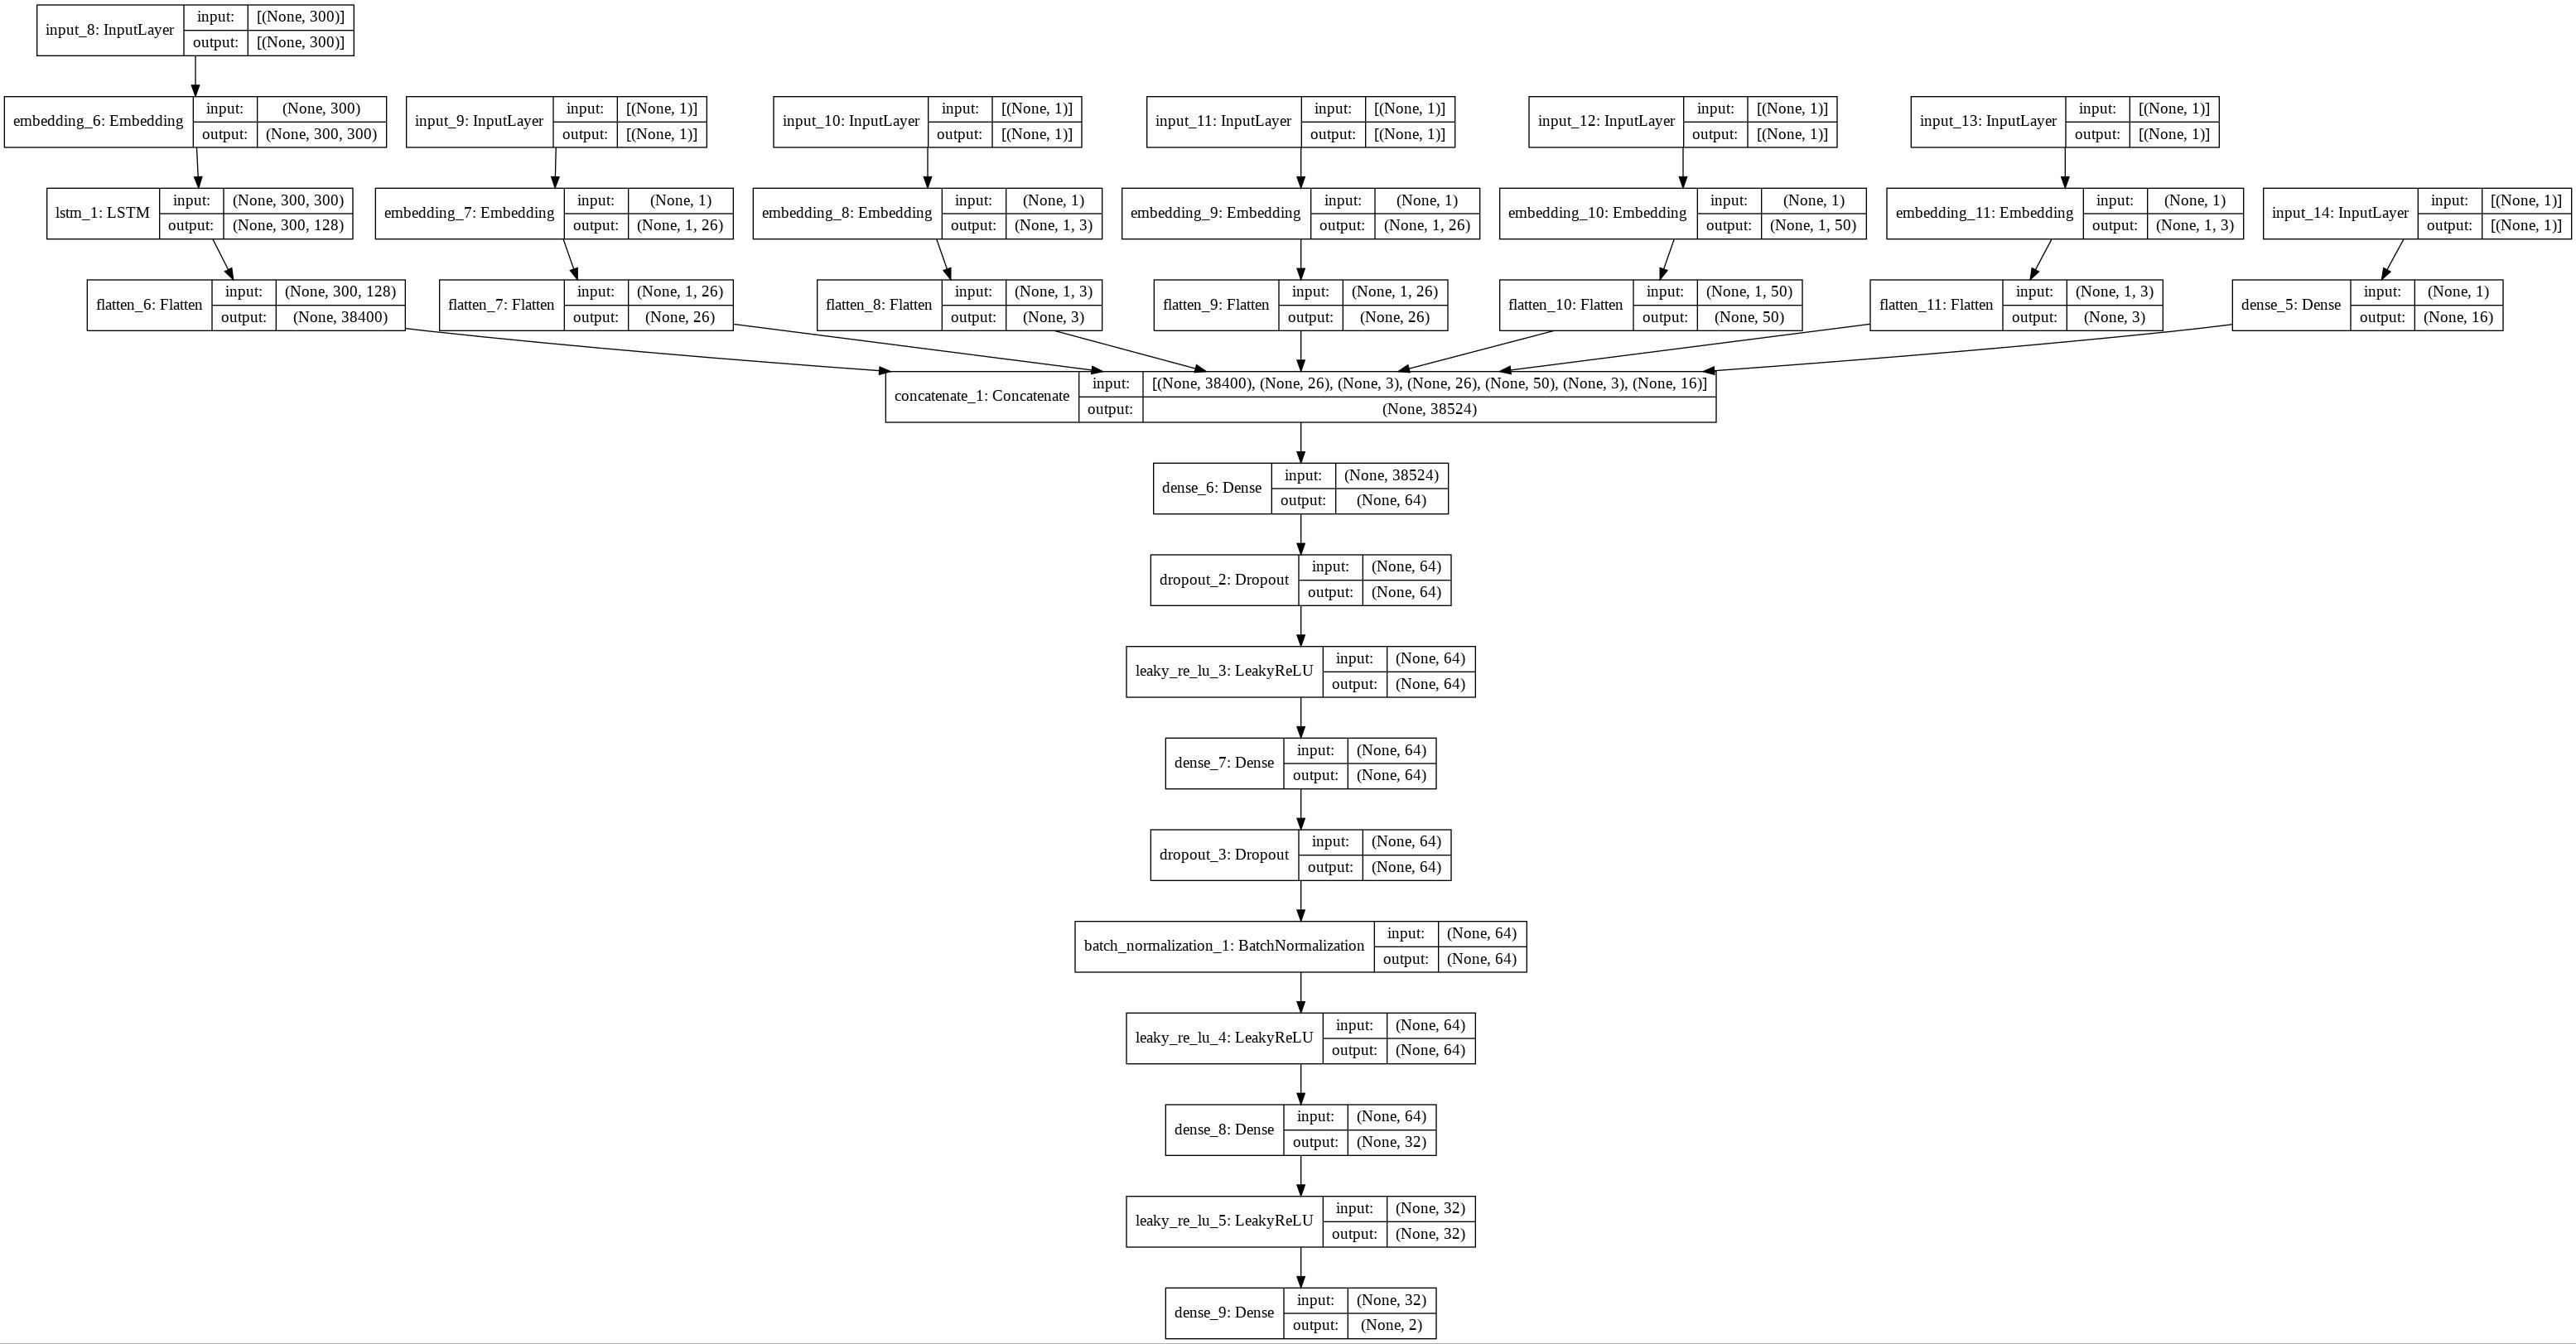

In [52]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/model-1.jpg', show_shapes = True, show_layer_names=True)

In [53]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import datetime

filepath = '/content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model1.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_auc_score', verbose=1, save_best_only=True, mode='max')
log_dir = "logs/fit/model1_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback1 = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [checkpoint, tensorboard_callback1]

input_data = [X_train_essay, X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_teacher_prefix_ohe, X_train['teacher_number_of_previously_posted_projects'] + X_train['price']]
val_data = [X_cv_essay, X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv['teacher_number_of_previously_posted_projects'] + X_cv['price']]

model.fit(input_data, Y_train, epochs=20, verbose=1, batch_size=512, validation_data=(val_data, Y_cv), callbacks=callbacks)

Epoch 1/20
137/137 [==============================] - 186s 1s/step - loss: 0.6895 - auc_score: 0.8376 - val_loss: 0.5451 - val_auc_score: 0.8655

Epoch 00001: val_auc_score improved from -inf to 0.86546, saving model to /content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model1.hdf5
Epoch 2/20
137/137 [==============================] - 178s 1s/step - loss: 0.4550 - auc_score: 0.8758 - val_loss: 0.4365 - val_auc_score: 0.8940

Epoch 00002: val_auc_score improved from 0.86546 to 0.89403, saving model to /content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model1.hdf5
Epoch 3/20
137/137 [==============================] - 177s 1s/step - loss: 0.4271 - auc_score: 0.8978 - val_loss: 0.4147 - val_auc_score: 0.9038

Epoch 00003: val_auc_score improved from 0.89403 to 0.90382, saving model to /content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model1.hdf5
Epoch 4/20
137/137 [==============================] - 178s 1s/step - loss: 0.4241 - auc_score: 0.8998 - va

In [54]:
X_test_data = [X_test_essay, X_test_school_state_ohe, X_test_project_grade_category_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_teacher_prefix_ohe, X_test['teacher_number_of_previously_posted_projects'] + X_test['price']]
roc_auc_score(Y_test, model.predict(X_test_data))

0.749788846642095

In [55]:
model.save("model_1.h5")

In [56]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/logs/fit/model1_20210524-070152

# Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer(min_df = 5, max_features = 10000)
tfidf = vectorizer.fit(X_train['essay'])

In [ ]:
idf = vectorizer.idf_

In [ ]:
df = pd.DataFrame(idf, columns=['idf_value'])
df.head()

,idf_value
0,7.151146
1,5.905117
2,4.503973
3,3.811063
4,7.295280


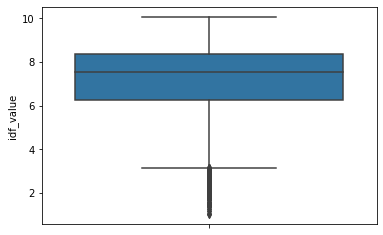

In [ ]:
import seaborn as sns

sns.boxplot(y = 'idf_value', data = df)

In [ ]:
for i in range(0, 100, 5):
    var = idf
    var = np.sort(var, axis = None)
    print(i, 'th percentile value is ', var[int(len(var)*(float(i)/100))])

print('100th percentile value is ', var[-1])

0 th percentile value is  1.0079982620655068
5 th percentile value is  4.107903145997144
10 th percentile value is  4.959905387988936
15 th percentile value is  5.461769039897696
20 th percentile value is  5.880330686925706
25 th percentile value is  6.266214749834764
30 th percentile value is  6.594411077152118
35 th percentile value is  6.871888979429657
40 th percentile value is  7.111667591248398
45 th percentile value is  7.342908352795227
50 th percentile value is  7.549922522179553
55 th percentile value is  7.724275909324332
60 th percentile value is  7.89241283112633
65 th percentile value is  8.044218843994333
70 th percentile value is  8.203848989586218
75 th percentile value is  8.348430218397326
80 th percentile value is  8.491531062038
85 th percentile value is  8.628732183551485
90 th percentile value is  8.75389532650549
95 th percentile value is  8.896996170146164
100th percentile value is  10.075651166487809


In [ ]:
feature_idf = zip(tfidf.get_feature_names(), idf)

feature_names = []

for x,y in feature_idf:
    if y >= 4 and y <= 9:
        feature_names.append(x)

print(len(feature_names))

9322


In [ ]:
from tqdm import tqdm

def get_idf_feature_text(essay):
    preprocessed_text = []

    for text in tqdm(essay):
        words = text.split()
        final_text = ''

        for word in words:
            if word in feature_names:
                final_text += ' ' + word
        preprocessed_text.append(final_text)

    return preprocessed_text

In [ ]:
print(X_train['essay'][0:2])

83805    mount carmel area school district provides fre...
69295    i kindergarten class 24 students they bright e...
Name: essay, dtype: object


In [ ]:
sample_preprocessed = get_idf_feature_text(X_train['essay'][0:2])
print(sample_preprocessed)

100%|██████████| 2/2 [00:00<00:00, 59.08it/s]

[' mount provides fresh strategies accommodate enthusiastic methods 60 12 mount national to qualify 15 2015 130 line 49 to qualify 21 annual 2015 line 11 slowly closing gap hybrid funding easily adapt assign advanced noticed found voice online collaborative assignments soar excitement comment increases communicate online', ' 24 bright eyed south side los angeles qualify welcome conditions maximize engagement ribbons rulers integrating decorate journals colorful ribbons journals interesting ruler cutting ribbons certain measurements measure inches rulers measure cut desired ribbons certain measurements journals colorful']


In [ ]:
X_train_idf_essay = get_idf_feature_text(X_train['essay'])
len(X_train_idf_essay)

100%|██████████| 69918/69918 [20:33<00:00, 56.66it/s]


69918

In [ ]:
X_cv_idf_essay = get_idf_feature_text(X_cv['essay'])
len(X_cv_idf_essay)

100%|██████████| 17480/17480 [05:06<00:00, 57.05it/s]


17480

In [ ]:
X_test_idf_essay = get_idf_feature_text(X_test['essay'])
len(X_test_idf_essay)

100%|██████████| 21850/21850 [06:25<00:00, 56.72it/s]


21850

In [ ]:
X_train_idf_df = pd.DataFrame(X_train_idf_essay)
X_train_idf_df.to_csv('/content/drive/My Drive/LSTM_Assignment/data/X_train_idf_essay.csv',index=False)

X_cv_idf_df = pd.DataFrame(X_cv_idf_essay)
X_cv_idf_df.to_csv('/content/drive/My Drive/LSTM_Assignment/data/X_cv_idf_essay.csv',index=False)

X_test_idf_df = pd.DataFrame(X_test_idf_essay)
X_test_idf_df.to_csv('/content/drive/My Drive/LSTM_Assignment/data/X_test_idf_essay.csv',index=False)

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_train_idf_essay)

vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(X_train_idf_essay)
X_train_essay = padded(encoded_docs)

In [ ]:
X_train.shape

(69918, 8)

In [ ]:
encoded_docs = t.texts_to_sequences(X_cv_idf_essay)
X_cv_essay = padded(encoded_docs)

encoded_docs = t.texts_to_sequences(X_test_idf_essay)
X_test_essay = padded(encoded_docs)

In [ ]:
embedding_matrix_2 = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_2[i] = embedding_vector

In [ ]:
X_train_essay_mat = embedding_matrix_2
X_train_essay_mat.shape

(9323, 300)

In [ ]:
from tensorflow.keras import backend
backend.clear_session()

input1 = Input(shape=(300,))
i1 = Embedding(input_dim= embedding_matrix_2.shape[0], output_dim = 300, weights = [embedding_matrix_2], input_length = 300, trainable = False)(input1)
i1 = LSTM(256, recurrent_dropout=0.3, kernel_regularizer=l2(0.0001), return_sequences=True)(i1)
i1 = Flatten()(i1)

cat_vars = ["teacher_prefix","school_state","project_grade_category","clean_categories","clean_subcategories"]
cat_sizes = {}
cat_embsizes = {}

for cat in cat_vars:
    cat_sizes[cat] = X_train[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

input2 = Input(shape=(1,))
i2 = Embedding(input_dim=cat_sizes['school_state']+1, output_dim=cat_embsizes['school_state'])(input2)
i2 = Flatten()(i2)

input3 = Input(shape=(1,))
i3 = Embedding(input_dim=cat_sizes['project_grade_category']+1, output_dim=cat_embsizes['project_grade_category'])(input3)
i3 = Flatten()(i3)

input4 = Input(shape=(1,))
i4 = Embedding(input_dim=cat_sizes['clean_categories']+1, output_dim=cat_embsizes['clean_categories'])(input4)
i4 = Flatten()(i4)

input5 = Input(shape=(1,))
i5 = Embedding(input_dim=cat_sizes['clean_subcategories']+1, output_dim=cat_embsizes['clean_subcategories'])(input5)
i5 = Flatten()(i5)

input6 = Input(shape=(1,))
i6 = Embedding(input_dim=cat_sizes['teacher_prefix']+1, output_dim=cat_embsizes['teacher_prefix'])(input6)
i6 = Flatten()(i6)

input7 = Input(shape=(1,))
i7 = Dense(16, kernel_initializer = he_normal(), kernel_regularizer = l2(0.0001))(input7)

concat = concatenate([i1, i2, i3, i4, i5, i6, i7])

i = Dense(64, kernel_initializer = he_normal(), kernel_regularizer = l2(0.0001))(concat)
i = Dropout(0.5)(i)
i = LeakyReLU()(i)
i = Dense(32, kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(i)
i = Dropout(0.5)(i)
i = BatchNormalization()(i)
i = LeakyReLU()(i)
i = Dense(16, kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(i)
i = LeakyReLU()(i)

output = Dense(2, activation = 'softmax')(i)
model2 = Model([input1, input2, input3, input4, input5, input6, input7], output)
model2.run_eagerly = True

adam = Adam(learning_rate=0.0001, decay = 1e-4)

model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = [auc_score])
print(model2.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 300)     2796900     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
______________________________________________________________________________________________

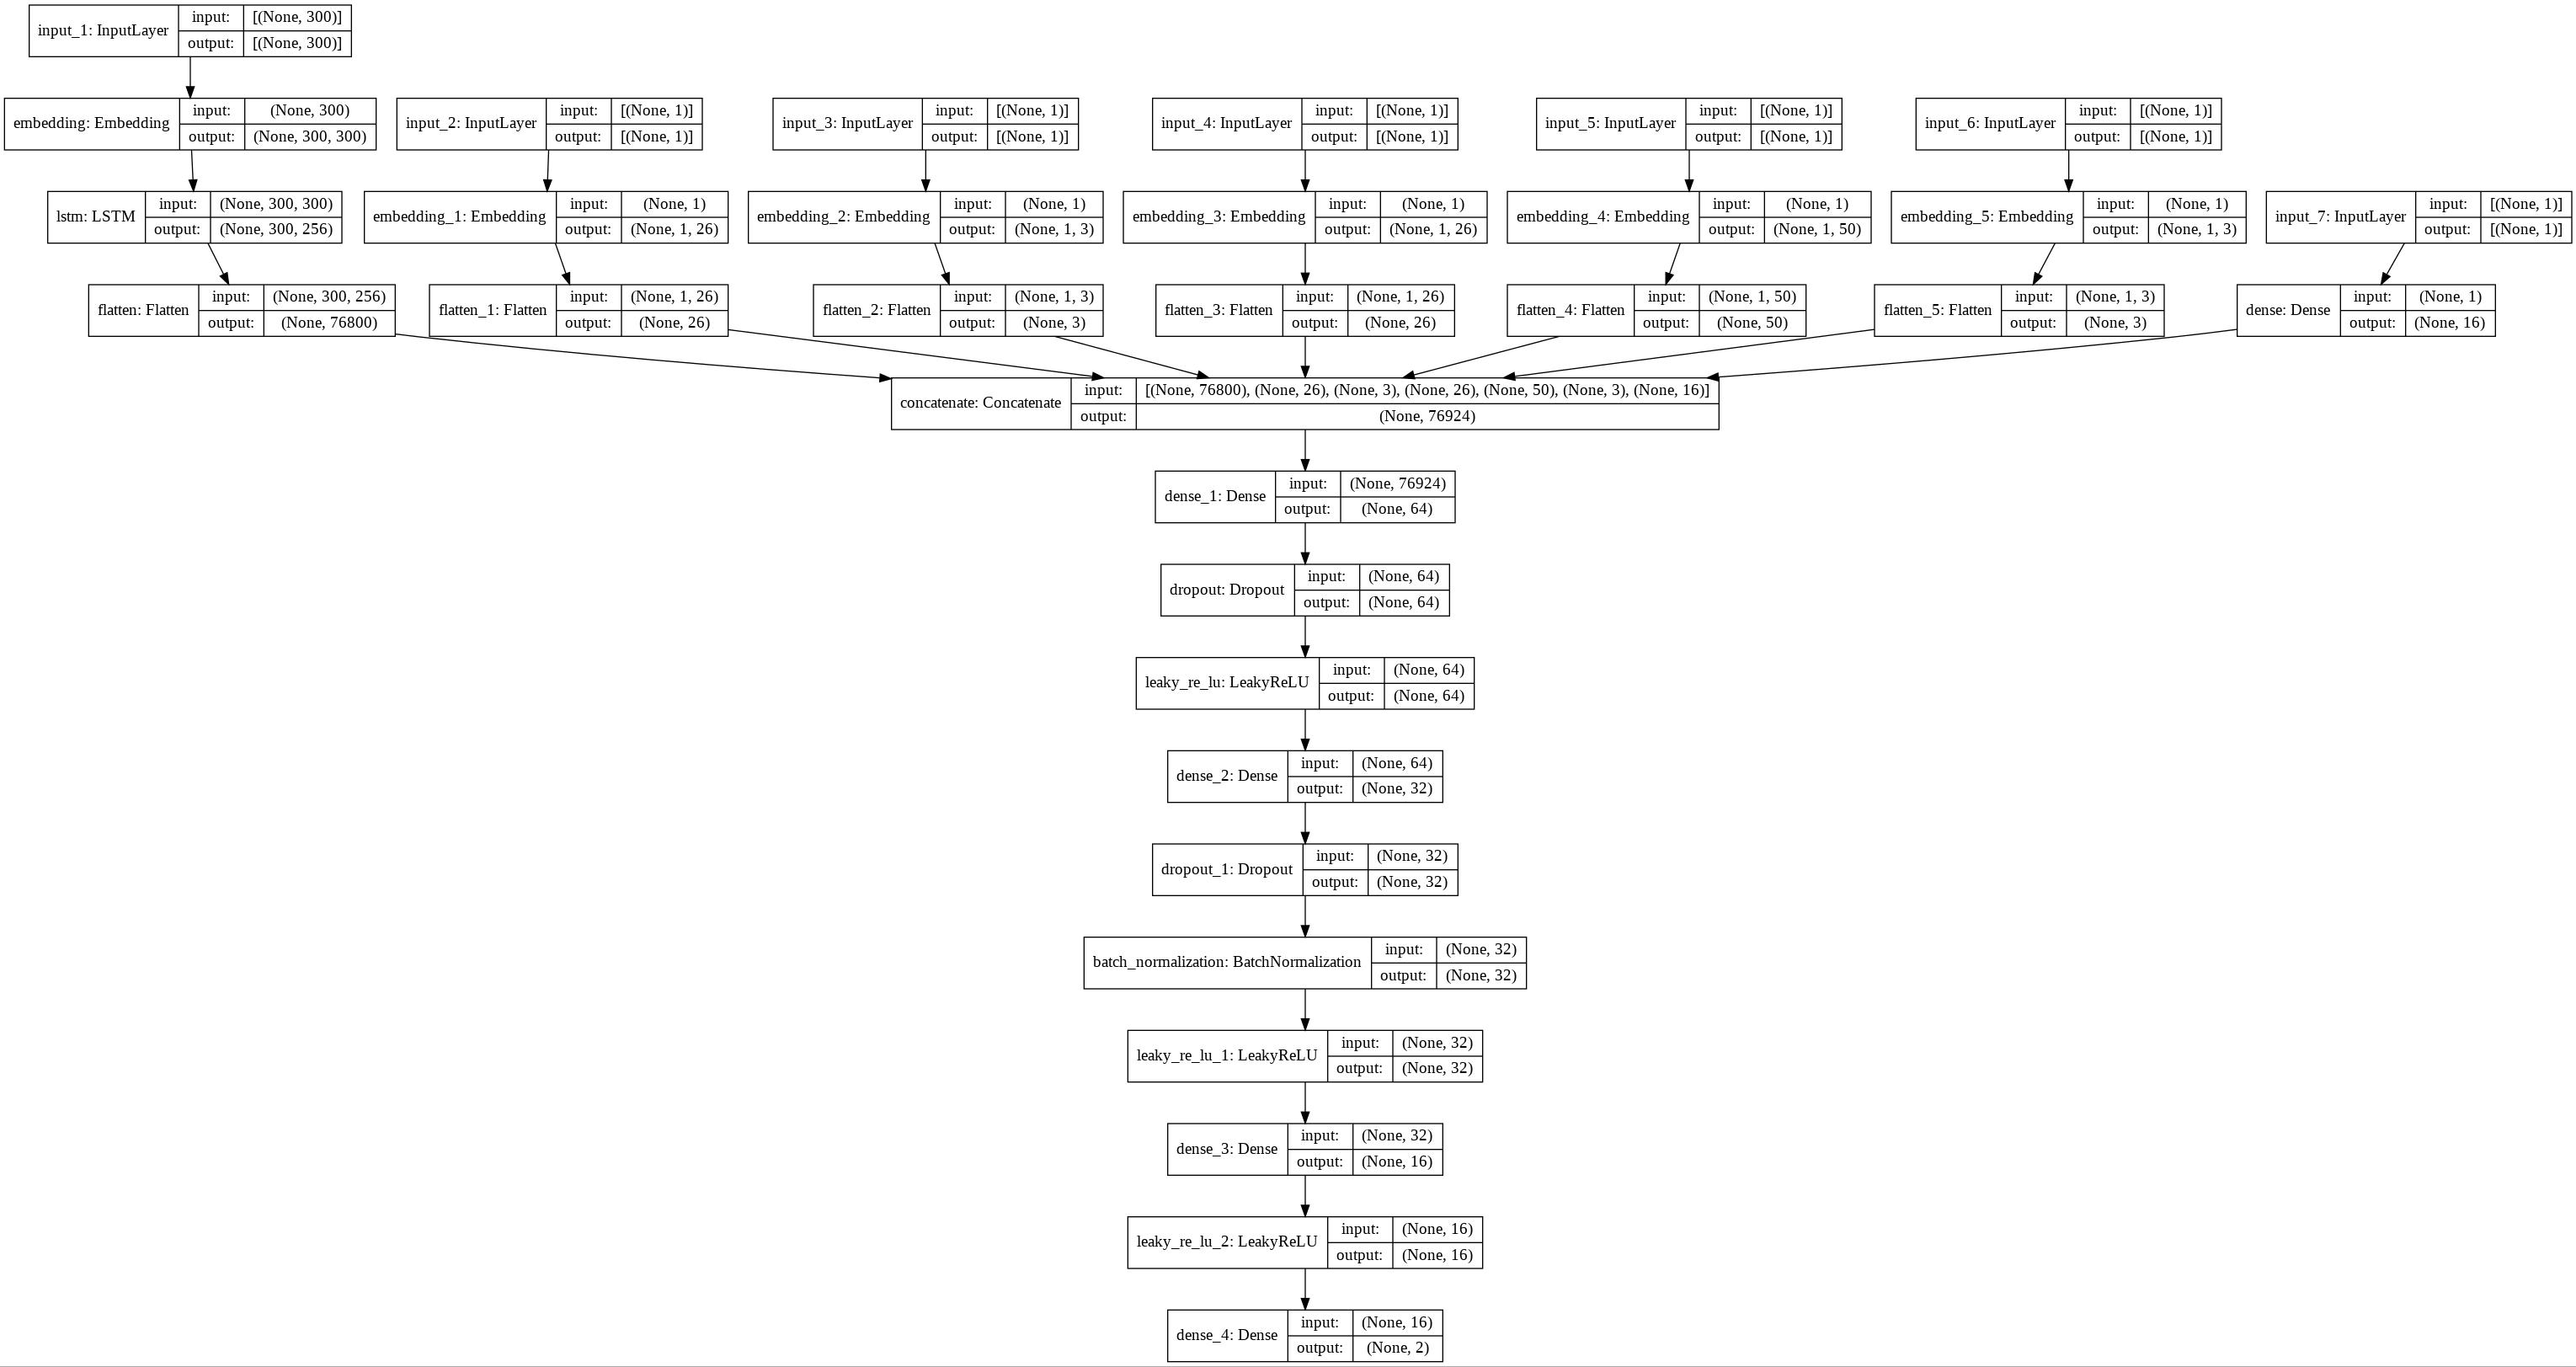

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='/content/model-2.jpg', show_shapes = True, show_layer_names=True)

In [ ]:
filepath = '/content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model2.hdf5'

earlyStop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_auc_score', verbose=1, save_best_only=True, mode='max')
log_dir = "logs/fit/model2_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [checkpoint, tensorboard_callback2]

input_data = [X_train_essay, X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_teacher_prefix_ohe,
              X_train['teacher_number_of_previously_posted_projects'] + X_train['price']]
val_data = [X_cv_essay, X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_teacher_prefix_ohe, 
            X_cv['teacher_number_of_previously_posted_projects'] + X_cv['price']]

model2.fit(input_data, Y_train, epochs=15, verbose=1, batch_size=400, validation_data=(val_data, Y_cv), callbacks=callbacks)

Epoch 1/15
175/175 [==============================] - 140s 782ms/step - loss: 0.7411 - auc_score: 0.6876 - val_loss: 0.5451 - val_auc_score: 0.8816

Epoch 00001: val_auc_score improved from -inf to 0.88159, saving model to /content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model2.hdf5
Epoch 2/15
175/175 [==============================] - 133s 761ms/step - loss: 0.5323 - auc_score: 0.8525 - val_loss: 0.4709 - val_auc_score: 0.8911

Epoch 00002: val_auc_score improved from 0.88159 to 0.89109, saving model to /content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model2.hdf5
Epoch 3/15
175/175 [==============================] - 132s 756ms/step - loss: 0.4919 - auc_score: 0.8696 - val_loss: 0.4611 - val_auc_score: 0.8945

Epoch 00003: val_auc_score improved from 0.89109 to 0.89447, saving model to /content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model2.hdf5
Epoch 4/15
175/175 [==============================] - 133s 757ms/step - loss: 0.4714 - auc_score:

In [ ]:
X_test_data = [X_test_essay, X_test_school_state_ohe, X_test_project_grade_category_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_teacher_prefix_ohe, X_test['teacher_number_of_previously_posted_projects'] + X_test['price']]
roc_auc_score(Y_test, model2.predict(X_test_data))

0.7042613687126467

In [ ]:
model2.save("model_2.h5")

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir /content/logs/fit/model2_20210521-190707

## Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values)

X_train_school_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_school_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_school_state_ohe = vectorizer.transform(X_test['school_state'].values)

school_state_features = vectorizer.get_feature_names()

print(X_train_school_state_ohe.shape, Y_train.shape)
print(X_cv_school_state_ohe.shape, Y_cv.shape)
print(X_test_school_state_ohe.shape, Y_test.shape)

(69918, 51) (69918, 2)
(17480, 51) (17480, 2)
(21850, 51) (21850, 2)


In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values)

X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

clean_categories_features = vectorizer.get_feature_names()

print(X_train_clean_categories_ohe.shape, Y_train.shape)
print(X_cv_clean_categories_ohe.shape, Y_cv.shape)
print(X_test_clean_categories_ohe.shape, Y_test.shape)

(69918, 9) (69918, 2)
(17480, 9) (17480, 2)
(21850, 9) (21850, 2)


In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values)

X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

clean_subcategories_features = vectorizer.get_feature_names()

print(X_train_clean_subcategories_ohe.shape, Y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, Y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, Y_test.shape)

(69918, 30) (69918, 2)
(17480, 30) (17480, 2)
(21850, 30) (21850, 2)


In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values)

X_train_project_grade_category_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer.transform(X_test['project_grade_category'].values)

project_grade_category_features = vectorizer.get_feature_names()

print(X_train_project_grade_category_ohe.shape, Y_train.shape)
print(X_cv_project_grade_category_ohe.shape, Y_cv.shape)
print(X_test_project_grade_category_ohe.shape, Y_test.shape)

(69918, 4) (69918, 2)
(17480, 4) (17480, 2)
(21850, 4) (21850, 2)


In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values)

X_train_teacher_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

teacher_prefix_features = vectorizer.get_feature_names()

print(X_train_teacher_prefix_ohe.shape, Y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, Y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, Y_test.shape)

(69918, 5) (69918, 2)
(17480, 5) (17480, 2)
(21850, 5) (21850, 2)


In [ ]:
X_train_num_of_projects = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_cv_num_of_projects = X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
X_test_num_of_projects = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)

print(X_train_num_of_projects.shape, Y_train.shape)
print(X_cv_num_of_projects.shape, Y_cv.shape)
print(X_test_num_of_projects.shape, Y_test.shape)

(69918, 1) (69918, 2)
(17480, 1) (17480, 2)
(21850, 1) (21850, 2)


In [ ]:
X_train_price = X_train['price'].values.reshape(-1,1)
X_cv_price = X_cv['price'].values.reshape(-1,1)
X_test_price = X_test['price'].values.reshape(-1,1)

print(X_train_price.shape, Y_train.shape)
print(X_cv_price.shape, Y_cv.shape)
print(X_test_price.shape, Y_test.shape)

(69918, 1) (69918, 2)
(17480, 1) (17480, 2)
(21850, 1) (21850, 2)


In [ ]:
from scipy.sparse import hstack

X_train_orig = X_train
X_cv_orig = X_cv
X_test_orig = X_test

X_train_stacked = hstack((X_train_school_state_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, X_train_project_grade_category_ohe, X_train_teacher_prefix_ohe, X_train_num_of_projects, X_train_price)).todense()
X_cv_stacked = hstack((X_cv_school_state_ohe, X_cv_clean_categories_ohe, X_cv_clean_subcategories_ohe, X_cv_project_grade_category_ohe, X_cv_teacher_prefix_ohe, X_cv_num_of_projects, X_cv_price)).todense()
X_test_stacked = hstack((X_test_school_state_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, X_test_project_grade_category_ohe, X_test_teacher_prefix_ohe, X_test_num_of_projects, X_test_price)).todense()

In [ ]:
t = Tokenizer()
t.fit_on_texts(X_train['essay'])

vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(X_train['essay'])
X_train_essay = padded(encoded_docs)

In [ ]:
encoded_docs = t.texts_to_sequences(X_cv['essay'])
X_cv_essay = padded(encoded_docs)

encoded_docs = t.texts_to_sequences(X_test['essay'])
X_test_essay = padded(encoded_docs)

In [ ]:
embedding_matrix_3 = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_3[i] = embedding_vector

In [ ]:
X_train_essay_mat = embedding_matrix_3
X_train_essay_mat.shape
print(X_train_essay_mat.shape)

(47173, 300)


In [ ]:
X_train_stacked = np.resize(X_train_stacked,new_shape=(69918,100,1))
X_cv_stacked = np.resize(X_cv_stacked,new_shape=(17480,100,1))
X_test_stacked = np.resize(X_test_stacked,new_shape=(21850,100,1))

In [ ]:
X_train_stacked.shape

(69918, 100, 1)

In [ ]:
from keras.layers.convolutional import Conv1D
from keras.layers import LeakyReLU
from keras.layers import SpatialDropout1D, LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape
from keras import Input, Model
from keras.regularizers import l2
from keras.initializers import he_normal
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
from keras.optimizers import Adam

input1 = Input(batch_shape=(None,300))
i1 = Embedding(input_dim=embedding_matrix_3.shape[0],output_dim= 300,weights=[embedding_matrix_3],trainable = False)(input1)
i1 = Dropout(0.3)(i1)
i1 = LSTM(256, recurrent_dropout=0.3, kernel_regularizer=l2(0.001), return_sequences=True)(i1)
i1 = Flatten()(i1)

# input 2
input2 = Input(shape=(100,1))
i2 = Conv1D(filters=64,kernel_size=3,strides=1)(input2)
i2 = Conv1D(filters=64,kernel_size=3,strides=1)(i2)
i2 = Flatten()(i2)

# merging both the inputs
concat = concatenate([i1,i2])
i = Dense(64,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(concat)
i = Dropout(0.5)(i)
i = Dense(32,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(i)
i = Dropout(0.5)(i)
i = Dense(16,kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001))(i)
output = Dense(2, activation = 'softmax')(i)
 
# create model with two inputs
model3 = Model([input1,input2], output)
model3.run_eagerly = True

adam = Adam(learning_rate=0.0006, decay = 1e-4)
model3.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[auc_score])
print(model3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 300, 300)     14151900    input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 300, 300)     0           embedding_6[0][0]                
____________________________________________________________________________________________

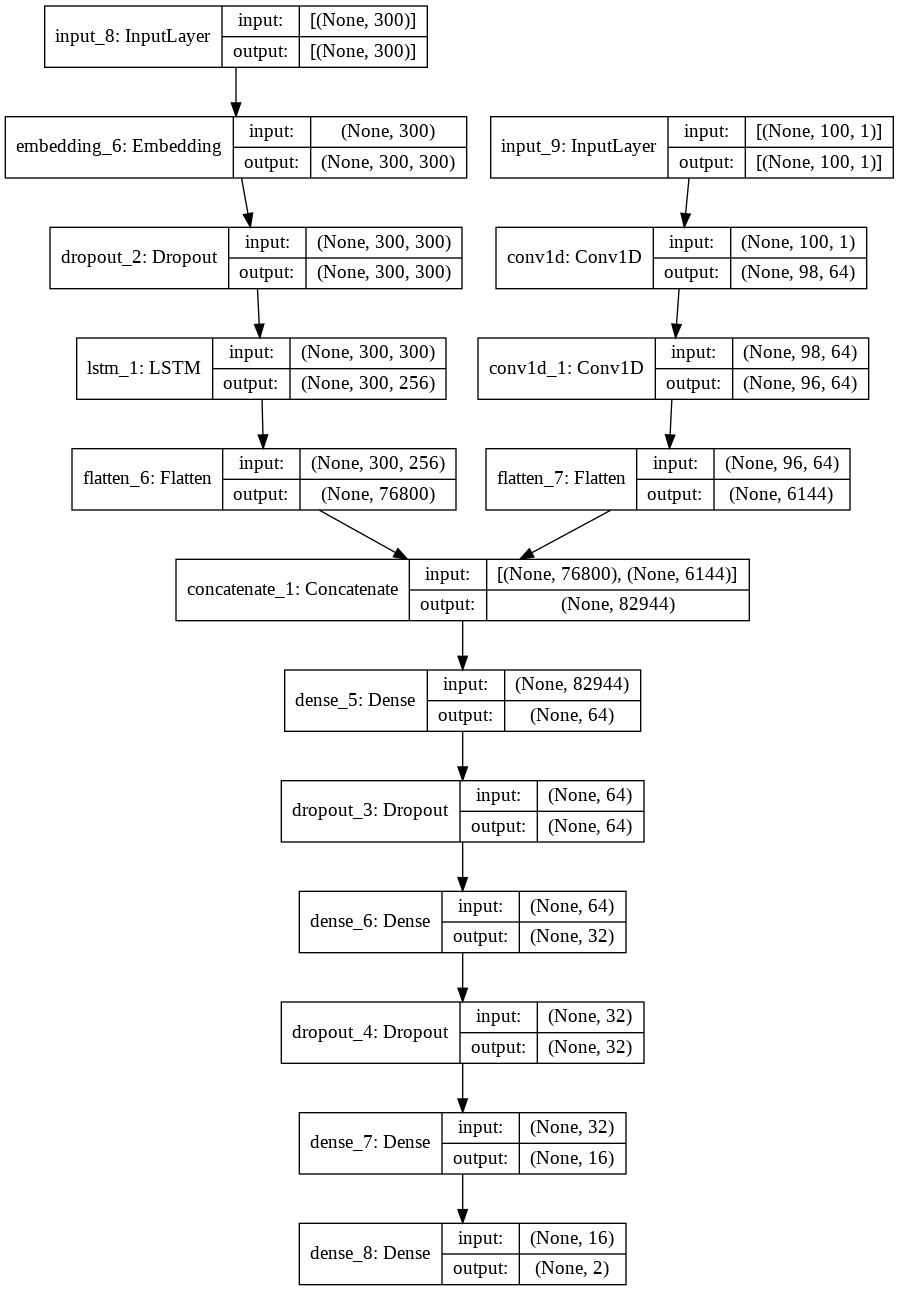

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='/content/model_3.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

filepath = '/content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model3.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_auc_score', verbose=1, save_best_only=True, mode='max')
log_dir = "logs/fit/model3_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback3 = TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks = [checkpoint, tensorboard_callback3]

model3.fit([X_train_essay, X_train_stacked], Y_train, epochs=20, verbose=1, batch_size=512, validation_data=([X_cv_essay, X_cv_stacked], Y_cv), callbacks=callbacks)

Epoch 1/20
137/137 [==============================] - 140s 812ms/step - loss: 3.1839 - auc_score: 0.7974 - val_loss: 0.6236 - val_auc_score: 0.8970

Epoch 00001: val_auc_score improved from -inf to 0.89701, saving model to /content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model3.hdf5
Epoch 2/20
137/137 [==============================] - 107s 779ms/step - loss: 0.6375 - auc_score: 0.8827 - val_loss: 0.5497 - val_auc_score: 0.8942

Epoch 00002: val_auc_score did not improve from 0.89701
Epoch 3/20
137/137 [==============================] - 106s 776ms/step - loss: 0.5691 - auc_score: 0.8874 - val_loss: 0.5182 - val_auc_score: 0.8975

Epoch 00003: val_auc_score improved from 0.89701 to 0.89748, saving model to /content/drive/My Drive/LSTM_Assignment/modelcheckpoint/weights_model3.hdf5
Epoch 4/20
137/137 [==============================] - 106s 775ms/step - loss: 0.5228 - auc_score: 0.8946 - val_loss: 0.4974 - val_auc_score: 0.8981

Epoch 00004: val_auc_score improved from 0.89

In [ ]:
X_test_data = [X_test_essay, X_test_stacked]
roc_auc_score(Y_test, model3.predict(X_test_data))

0.7073108281770057

In [ ]:
model3.save('model_3.h5')

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
%tensorboard --logdir /content/logs/fit/model3_20210521-194416